# River flow predictor

In [1]:
import data_processing as dp
import training as trn
import numpy as np
import pandas as pd

## Create a configured dataset, select and train models

In [16]:
 # Configure data processing
epochs = 1000
lrn = 0.1
hidden_layers = 1
nodes_per_layer = 5
std_range = (0.1, 0.9)
dataset_split = (0.6, 0.2, 0.2)

raw_df = dp.read_raw_csv()
raw_df = dp.remove_spurious_data(raw_df)

# Copy the DataFrame before discarding values
# as we will use the raw data for visualization
main_df = raw_df.copy()
raw_df.dropna(inplace=True)

# Lag all predictors by 1 day
for col in main_df.columns.values:
    if col[1] != "p":
        main_df = dp.lag_column(main_df, col, 1)

# Remove rows with empty data
main_df.dropna(inplace=True)

main_df = dp.split_data(main_df, dataset_split[0], dataset_split[1], dataset_split[2])
main_df, min_val, max_val = dp.standardise_data(main_df, std_range[0], std_range[1])
print(main_df.head().to_string() + "\n")






# ### Initialise and train neural network

main_data = main_df.to_numpy()
print(main_data)

network = trn.initialise_network(main_df.shape[1]-1, hidden_layers, nodes_per_layer)
print("Network created")

real_vals = pd.DataFrame([row[-1] for row in main_data])
real_vals = real_vals.apply(lambda x: dp.destandardise_val(x, std_range[0], std_range[1], min_val, max_val))

# Train using backpropagation and calculate root-mean-square error after every epoch
rmse_arr = []
for i in range(epochs):
    network, output_vals = trn.train(network, main_data, lrn)
    output_vals = output_vals.apply(lambda x: dp.destandardise_val(x, std_range[0], std_range[1], min_val, max_val))
    total_sq_err = 0
    for j in range(len(output_vals)):
        err = real_vals.iloc[j] - output_vals.iloc[j]
        total_sq_err += pow(err, 2)
    mean_sq_err = total_sq_err / len(output_vals)
    rmse_arr.append(np.sqrt(mean_sq_err))

# Record real values vs values modelled by trained network
mod_vals = trn.predict(network, main_data)
mod_vals = mod_vals.apply(lambda x: dp.destandardise_val(x, std_range[0], std_range[1], min_val, max_val))


print("Finished training network")

Loading raw data from datasets/raw/raw.csv
type                       f                             r                                       f
src                 f1 (t-1)  f2 (t-1)  f3 (t-1)  r1 (t-1)  r2 (t-1)  r3 (t-1)  r4 (t-1)         p
dataset date                                                                                      
trn     1994-08-09  0.084919  0.088238  0.083842  0.080000  0.080000  0.083065  0.083252  0.090672
        1996-03-16  0.117221  0.116062  0.096434  0.080000  0.080000  0.083065  0.080000  0.137703
        1994-12-05  0.252304  0.292888  0.212983  0.173783  0.296425  0.346667  0.223089  0.410181
        1995-10-05  0.106723  0.084732  0.130278  0.102735  0.137971  0.138238  0.132033  0.142299
        1996-12-29  0.113183  0.129120  0.100332  0.119787  0.134106  0.098391  0.099512  0.137146

[[0.08491878 0.08823771 0.08384191 ... 0.08306513 0.08325203 0.09067244]
 [0.11722125 0.11606189 0.09643398 ... 0.08306513 0.08       0.13770344]
 [0.2523043  0.292

KeyboardInterrupt: 

## Data visualization

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons, CheckButtons
%matplotlib widget
plt.close("all")
vis_df = main_df.copy()

### Plot data by type and cull by std devs

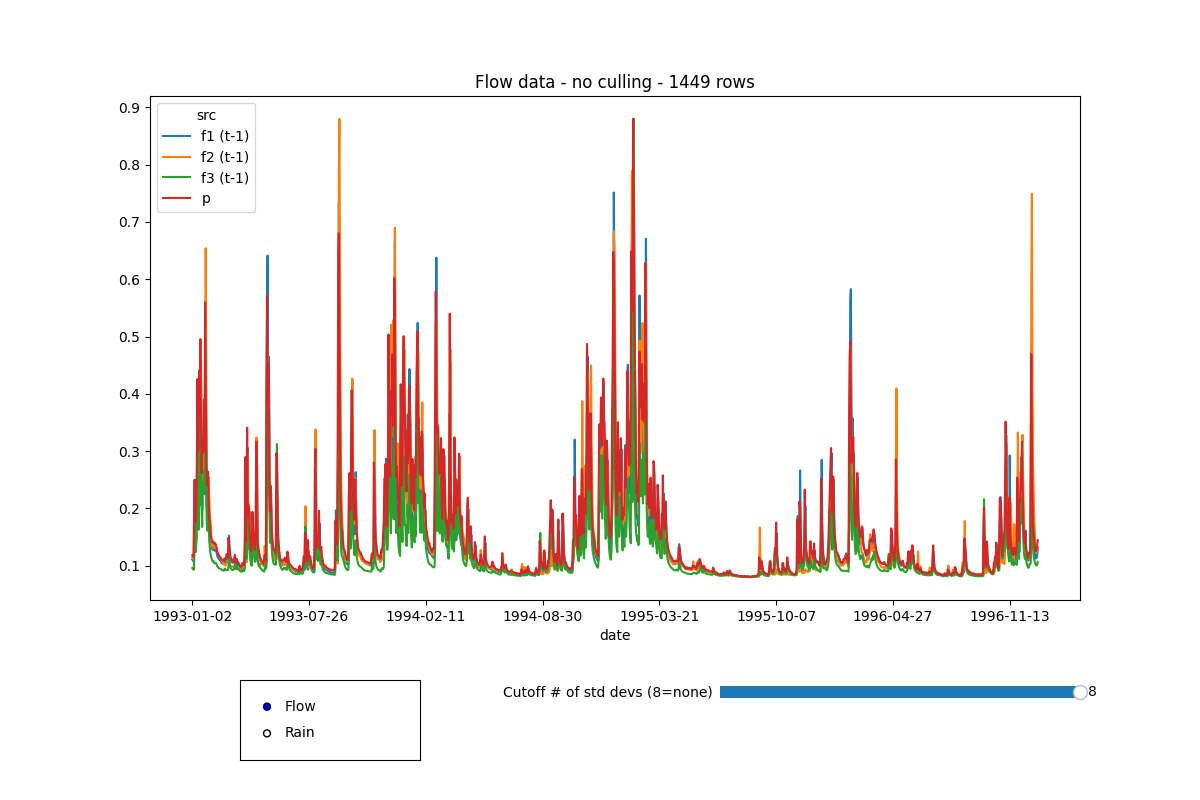

In [10]:
plt.close("all")
std_df = vis_df.droplevel(level=0).sort_index()

# ============================ GRAPH ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
fig, ax_graph = plt.subplots()
ax_buttons = fig.add_axes([0.2, 0.05, 0.15, 0.1])
ax_slider = fig.add_axes([0.6, 0.12, 0.3, 0.03])
std_df["f"].plot(ax=ax_graph,
    title=f"Flow data - no culling - {std_df.shape[0]} rows")



# ============================== COMPONENTS ================================


# Radio buttons for flow/rain

dataset_radio = RadioButtons(ax=ax_buttons, labels=["Flow", "Rain"])



# Slider for # of std devs

sd_slider = Slider(ax=ax_slider, label="Cutoff # of std devs (8=none)",
                   valmin=1, valmax=8, valinit=8, valstep=1)

# ======================== EVENT HANDLER FUNCTIONS =======================

def std_update(val):
    data_type = dataset_radio.value_selected
    sd = sd_slider.val

    std_data = std_df.copy()
    title_text = f"{data_type} data - no culling - {std_data.shape[0]} rows"
    if sd != 8:
        std_data = std_data[np.abs(std_data - std_data.std()) <= std_data.mean() + sd * std_data.std()]
        std_data.dropna(inplace=True)
        title_text = f"{data_type} data - culling values >{sd} std devs from mean - {std_data.shape[0]} rows"

    ax_graph.clear()

    dt = data_type[0].lower()
    if dt == "f":
        std_ax_data = std_data.loc[:, dt]
    else:
        std_ax_data = std_data[[c for c in std_data if c[1][0] != "f"]]
    std_ax_data.plot(ax=ax_graph, title=title_text)
    fig.subplots_adjust(bottom=0.25)
    fig.canvas.draw()


dataset_radio.on_clicked(std_update)
sd_slider.on_changed(std_update)

# Figure styling
fig.subplots_adjust(bottom=0.25)
fig.set_size_inches((12, 8))
fig.canvas.header_visible = False

### Plot predictand against predictors with transformations

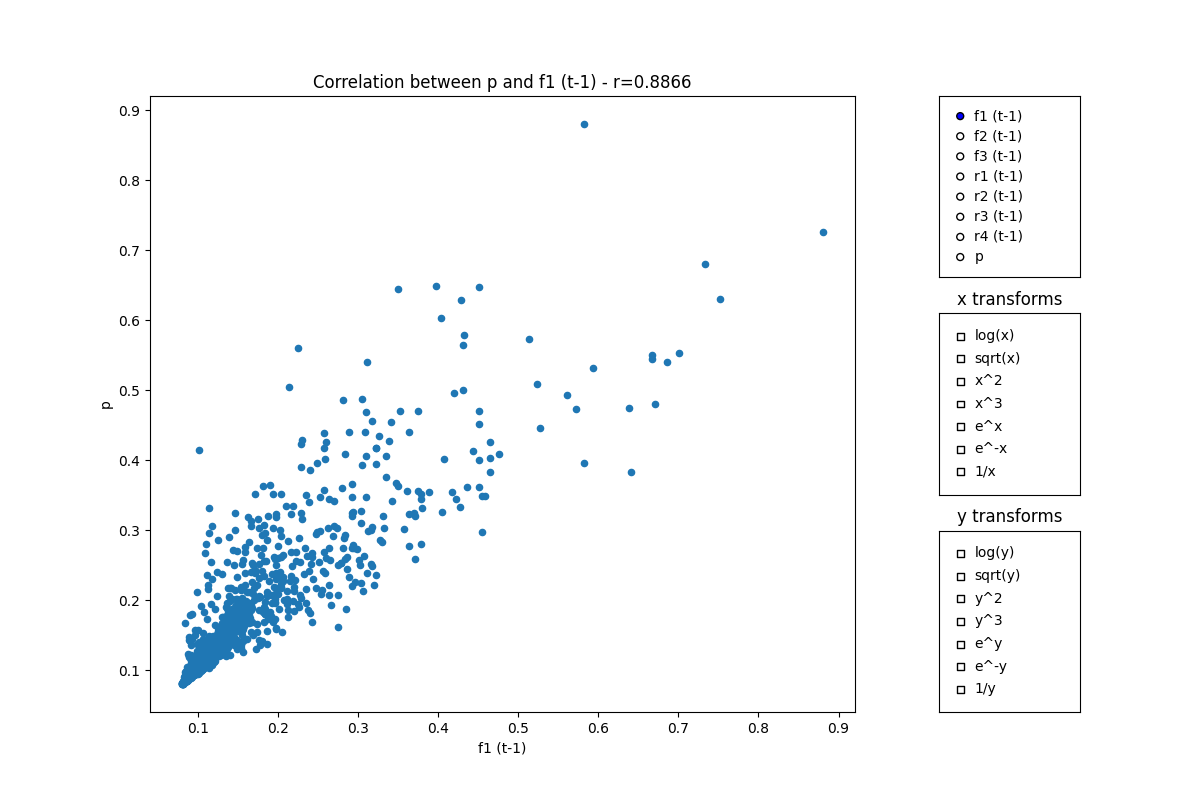

In [5]:
plt.close("all")
corr_data = vis_df.droplevel(level=0)
corr_data = corr_data.droplevel(level=0, axis=1)

# ============================ GRAPHS ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
corr_fig, corr_axes = plt.subplot_mosaic(
    [
        ["main", "xdata"],
        ["main", "x_transforms"],
        ["main", "y_transforms"],
    ],
    width_ratios=[5, 1])
corr_axes["x_transforms"].set_title("x transforms")
corr_axes["y_transforms"].set_title("y transforms")

pd_init_x = corr_data.columns[0]
corr_init = corr_data.corr()["p"][pd_init_x]
corr_data.plot(x=pd_init_x, y="p", kind="scatter", ax=corr_axes["main"],
               title=f"Correlation between p and {pd_init_x} - r={corr_init:.4f}")

# ============================== COMPONENTS ================================


# Radio buttons for predictor to plot

predictor_radio = RadioButtons(ax=corr_axes["xdata"],
                               labels=corr_data.columns)

# Check buttons for predictor transforms

def transform_labels(axis):
    return [f"log({axis})",
            f"sqrt({axis})",
            f"{axis}^2",
            f"{axis}^3",
            f"e^{axis}",
            f"e^-{axis}",
            f"1/{axis}",]

x_transform_checks = CheckButtons(ax=corr_axes["x_transforms"],
                                labels=transform_labels("x"))


# Check buttons for predictand transforms

y_transform_checks = CheckButtons(ax=corr_axes["y_transforms"],
                                  labels=transform_labels("y"))

# ======================== EVENT HANDLER FUNCTIONS =======================

def apply_transforms(checks, dat):
    transforms = checks.get_status()
    if transforms[0]: dat = dat.apply(np.log)
    if transforms[1]: dat = dat.apply(np.sqrt)
    if transforms[2]: dat = dat.apply(np.square)
    if transforms[3]: dat = dat.apply(lambda x: np.power(x, 3))
    if transforms[4]: dat = dat.apply(lambda x: np.power(np.e, x))
    if transforms[5]: dat = dat.apply(lambda x: np.power(np.e, -x))
    if transforms[6]: dat = dat.apply(lambda x: 1 / x if x != 0 else 0)
    return dat

def pd_update(val):
    prd = predictor_radio.value_selected

    c_data = corr_data.copy()

    c_data[prd] = apply_transforms(x_transform_checks, c_data[prd])
    c_data["p"] = apply_transforms(y_transform_checks, c_data["p"])

    corr = c_data.corr()["p"][prd]

    corr_axes["main"].clear()
    c_data.plot(x=prd, y="p", kind="scatter", ax=corr_axes["main"],
                title=f"Correlation between p and {prd} - r={corr:.4f}")
    corr_fig.canvas.draw()

predictor_radio.on_clicked(pd_update)
x_transform_checks.on_clicked(pd_update)
y_transform_checks.on_clicked(pd_update)

# Figure styling
corr_fig.set_size_inches((12, 8))
corr_fig.canvas.header_visible = False

### Heatmap of correlations between all columns

In [6]:
heatmap_df = vis_df.droplevel(level=0, axis=1).corr()
heatmap_df.style.background_gradient(cmap='Blues')

src,f1 (t-1),f2 (t-1),f3 (t-1),r1 (t-1),r2 (t-1),r3 (t-1),r4 (t-1),p
src,,,,,,,,
f1 (t-1),1.000000,0.931568,0.898979,0.329366,0.238756,0.306136,0.365255,0.886649
f2 (t-1),0.931568,1.000000,0.865723,0.370758,0.257217,0.325094,0.364167,0.885243
f3 (t-1),0.898979,0.865723,1.000000,0.471403,0.294261,0.480385,0.556395,0.913416
r1 (t-1),0.329366,0.370758,0.471403,1.000000,0.601168,0.595872,0.635101,0.507140
r2 (t-1),0.238756,0.257217,0.294261,0.601168,1.000000,0.439301,0.423620,0.340427
r3 (t-1),0.306136,0.325094,0.480385,0.595872,0.439301,1.000000,0.687929,0.491666
r4 (t-1),0.365255,0.364167,0.556395,0.635101,0.423620,0.687929,1.000000,0.580775
p,0.886649,0.885243,0.913416,0.507140,0.340427,0.491666,0.580775,1.000000


### RMSE of model during training

Text(0, 0.5, 'Root MSE')

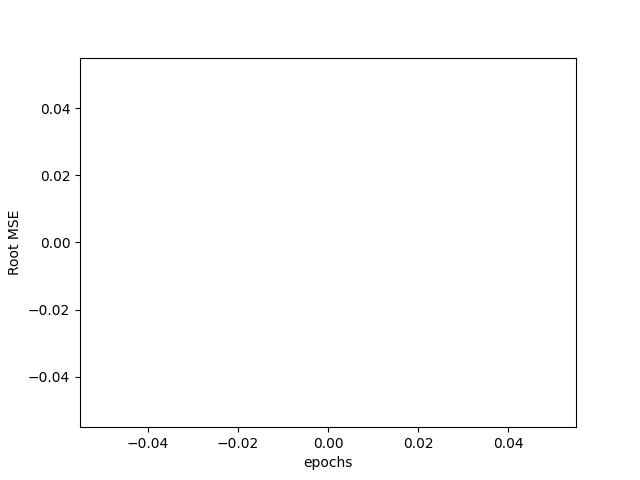

In [11]:
plt.close("all")

rmse_fig, rmse_ax_graph = plt.subplots()

rmse_ax_graph.plot(rmse_arr)

plt.xlabel("epochs")
plt.ylabel("Root MSE")

### Modelled vs actual values

Text(0, 0.5, 'Modelled value')

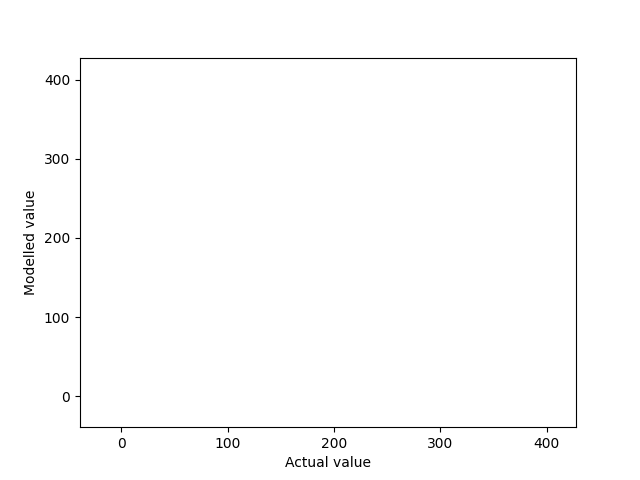

In [12]:
plt.close("all")

diff_fig, diff_ax_graph = plt.subplots()

diff_ax_graph.scatter(real_vals, mod_vals)
ax_max = float(real_vals.max().iloc[0])
plt.xlim(-ax_max*0.1, ax_max*1.1)
plt.ylim(-ax_max*0.1, ax_max*1.1)
plt.xlabel("Actual value")
plt.ylabel("Modelled value")